In [30]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
qaoa_results_path = "qaoa_dataset_parallel.npy"
qaoa_results = np.load(qaoa_results_path,allow_pickle=True).item()

qrl_results_path = "results_parallel.npy"
qrl_results = np.load(qrl_results_path,allow_pickle=True).item()

hwe_results_path = "results_parallel_hwe.npy"
hwe_results = np.load(hwe_results_path,allow_pickle=True).item()

In [32]:
types = ["slack","unbalanced"]
problem_sizes = [3,4,5,7,8,9,10]
dataset_size = 100

qaoa_final_results = {}

for type_ in types:
    qaoa_final_results[type_] = {}
    for problem_size in problem_sizes:
        qaoa_final_results[type_][problem_size] = {}
        for i in range(dataset_size):
            qaoa_final_results[type_][problem_size][f'{i}'] = {}
            qaoa_final_results[type_][problem_size][f'{i}']["optimal_probability"] = qaoa_results[type_][problem_size][f'{i}']["probability"]


In [33]:
dataset = np.load("/home/users/coelho/quantum-computing/QRL/games/knapsack/KP_dataset.npy",allow_pickle=True).item()
dataset["3"]["validation"]["0"]

for i, problem_size in enumerate(problem_sizes):
    aux_dataset = dataset[f"{problem_size}"]["validation"]

    values = []
    weights = []
    maximum_weight = []

    for j in range(100):
        values.append(aux_dataset[f"{j}"]["values"])
        weights.append(aux_dataset[f"{j}"]["weights"])
        maximum_weight.append(aux_dataset[f"{j}"]["maximum_weight"])

    items = len(values[0])
    actions = np.reshape(np.unpackbits(np.arange(2**items).astype('>i8').view(np.uint8)), (-1, 64))[:,-items:]
    random_probability = 1/(2**items)

    for j in range(100):
        probabilities_slack = qaoa_results["slack"][problem_size][f"{j}"]["probabilities"]
        probabilities_unbalanced = qaoa_results["unbalanced"][problem_size][f"{j}"]["probabilities"]

        probability_valid_slack = 0
        probability_valid_unbalanced = 0
        average_random_contribution = 0
        slack_contribution = 0
        unbalanced_contribution = 0

        for k, action in enumerate(actions):
            weight = sum(action[z]*weights[j][z] for z in range(items))
            if round(weight,2) <= maximum_weight[j]:
                contribution = sum(action[z]*values[j][z] for z in range(items))
                probability_valid_slack += probabilities_slack[k]
                probability_valid_unbalanced += probabilities_unbalanced[k]
                average_random_contribution += contribution * random_probability
                slack_contribution += probabilities_slack[k] * contribution
                unbalanced_contribution += probabilities_unbalanced[k] * contribution
        
        qaoa_final_results["slack"][problem_size][f'{j}']["valid_probability"] = probability_valid_slack
        qaoa_final_results["unbalanced"][problem_size][f'{j}']["valid_probability"] = probability_valid_unbalanced

        qaoa_final_results["slack"][problem_size][f'{j}']["better_than_random"] = slack_contribution/average_random_contribution
        qaoa_final_results["unbalanced"][problem_size][f'{j}']["better_than_random"] = unbalanced_contribution/average_random_contribution

In [34]:
qaoa_results_final = {}
for type_ in types:
    qaoa_results_final[type_] = {}
    for problem in problem_sizes:
        qaoa_results_final[type_][problem] = {}
        qaoa_results_final[type_][problem]["optimal_probability"] = []
        qaoa_results_final[type_][problem]["valid_probability"] = []
        qaoa_results_final[type_][problem]["better_than_random"] = []
        for i in range(dataset_size):
            qaoa_results_final[type_][problem]["optimal_probability"].append(qaoa_final_results[type_][problem][f'{i}']["optimal_probability"])
            qaoa_results_final[type_][problem]["valid_probability"].append(qaoa_final_results[type_][problem][f'{i}']["valid_probability"])
            qaoa_results_final[type_][problem]["better_than_random"].append(qaoa_final_results[type_][problem][f'{i}']["better_than_random"])


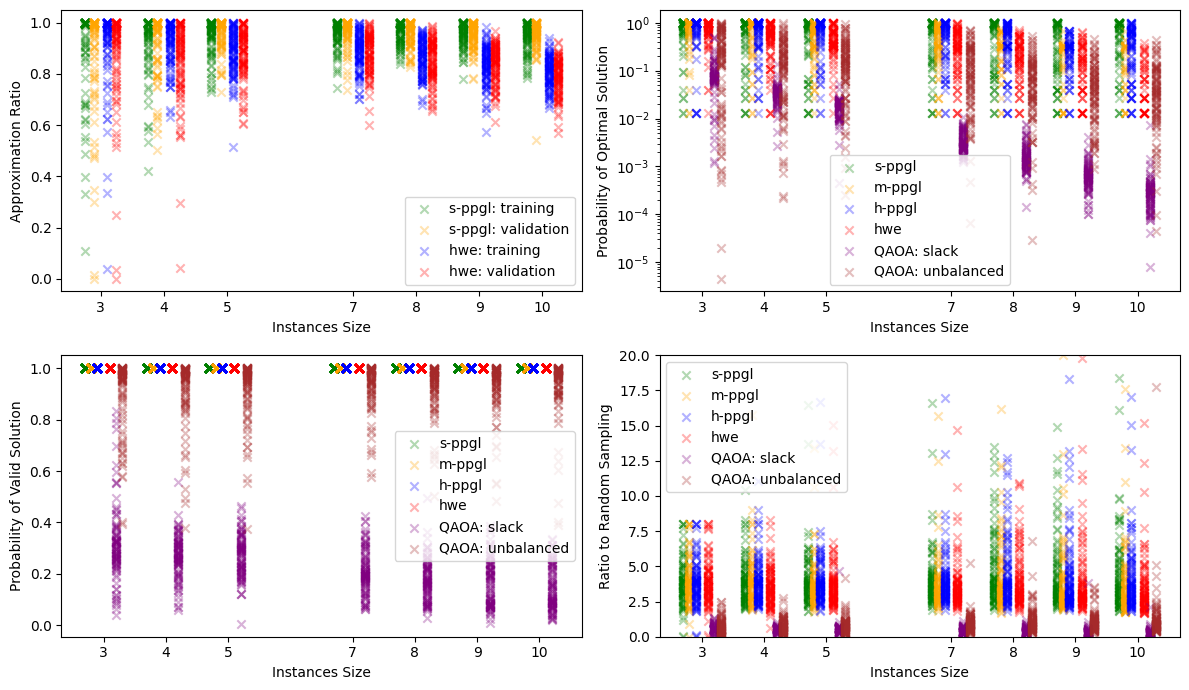

In [35]:
import matplotlib.pyplot as plt

# Assuming you have defined `problem_sizes` and `dataset_size` somewhere in your code

fig, ax = plt.subplots(2,2,tight_layout = True, figsize = (12,7))

# Plot the data as a vertical scatter plot
for i,size in enumerate(problem_sizes):
    ax[0,0].scatter([size - 0.25] * dataset_size, qrl_results["approximation_ratios"][f"{size}"]["=s-ppgl"]["test"], marker = "x",color='green', alpha=0.3, label="s-ppgl: training" if i == 0 else None)
    ax[0,0].scatter([size - 0.1] * dataset_size, qrl_results["approximation_ratios"][f"{size}"]["=s-ppgl"]["validation"], marker = "x",color='orange', alpha=0.3, label="s-ppgl: validation" if i == 0 else None)
    ax[0,0].scatter([size + 0.1] * dataset_size, hwe_results["approximation_ratios"][f"{size}"]["PG"]["test"], marker = "x",color='blue', alpha=0.3, label="hwe: training" if i == 0 else None)
    ax[0,0].scatter([size + 0.25] * dataset_size, hwe_results["approximation_ratios"][f"{size}"]["PG"]["validation"], marker = "x",color='red', alpha=0.3, label="hwe: validation" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[0,0].set_xticks(custom_ticks)

ax[0,0].set_xlabel("Instances Size")
ax[0,0].set_ylabel("Approximation Ratio")

# Manually create legend
ax[0,0].legend(["s-ppgl: training", "s-ppgl: validation","hwe: training","hwe: validation"])


for i,size in enumerate(problem_sizes):
    ax[0,1].scatter([size - 0.3] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=s-ppgl"]["validation"], marker = "x",color='green', alpha=0.3, label="s-ppgl" if i == 0 else None)
    ax[0,1].scatter([size - 0.2] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=m-ppgl"]["validation"], marker = "x",color='orange', alpha=0.3, label="m-ppgl" if i == 0 else None)
    ax[0,1].scatter([size - 0.1] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=h-ppgl"]["validation"], marker = "x",color='blue', alpha=0.3, label="h-ppgl" if i == 0 else None)
    ax[0,1].scatter([size + 0.1] * dataset_size, hwe_results["optimal_probability"][f"{size}"]["PG"]["validation"], marker = "x",color='red', alpha=0.3, label="hwe" if i == 0 else None)
    ax[0,1].scatter([size + 0.2] * dataset_size, qaoa_results_final["slack"][size]["optimal_probability"], marker = "x",color='purple', alpha=0.3, label="QAOA: slack" if i == 0 else None)
    ax[0,1].scatter([size + 0.3] * dataset_size, qaoa_results_final["unbalanced"][size]["optimal_probability"], marker = "x",color='brown', alpha=0.3, label="QAOA: unbalanced" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[0,1].set_xticks(custom_ticks)

ax[0,1].set_xlabel("Instances Size")
ax[0,1].set_ylabel("Probability of Optimal Solution")
ax[0,1].set_yscale("log")

# Manually create legend
ax[0,1].legend(["s-ppgl", "m-ppgl","h-ppgl","hwe", "QAOA: slack", "QAOA: unbalanced"])

for i,size in enumerate(problem_sizes):
    ax[1,0].scatter([size - 0.3] * dataset_size, qrl_results["valid_probability"][f"{size}"]["=s-ppgl"]["validation"], marker = "x",color='green', alpha=0.3, label="s-ppgl" if i == 0 else None)
    ax[1,0].scatter([size - 0.2] * dataset_size, qrl_results["valid_probability"][f"{size}"]["=m-ppgl"]["validation"], marker = "x",color='orange', alpha=0.3, label="m-ppgl" if i == 0 else None)
    ax[1,0].scatter([size - 0.1] * dataset_size, qrl_results["valid_probability"][f"{size}"]["=h-ppgl"]["validation"], marker = "x",color='blue', alpha=0.3, label="h-ppgl" if i == 0 else None)
    ax[1,0].scatter([size + 0.1] * dataset_size, hwe_results["valid_probability"][f"{size}"]["PG"]["validation"], marker = "x",color='red', alpha=0.3, label="hwe" if i == 0 else None)
    ax[1,0].scatter([size + 0.2] * dataset_size, qaoa_results_final["slack"][size]["valid_probability"], marker = "x",color='purple', alpha=0.3, label="QAOA: slack" if i == 0 else None)
    ax[1,0].scatter([size + 0.3] * dataset_size, qaoa_results_final["unbalanced"][size]["valid_probability"], marker = "x",color='brown', alpha=0.3, label="QAOA: unbalanced" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[1,0].set_xticks(custom_ticks)

ax[1,0].set_xlabel("Instances Size")
ax[1,0].set_ylabel("Probability of Valid Solution")

# Manually create legend
ax[1,0].legend(["s-ppgl", "m-ppgl","h-ppgl","hwe", "QAOA: slack", "QAOA: unbalanced"])


for i,size in enumerate(problem_sizes):
    ax[1,1].scatter([size - 0.3] * dataset_size, qrl_results["better_than_random"][f"{size}"]["=s-ppgl"]["validation"], marker = "x",color='green', alpha=0.3, label="s-ppgl" if i == 0 else None)
    ax[1,1].scatter([size - 0.2] * dataset_size, qrl_results["better_than_random"][f"{size}"]["=m-ppgl"]["validation"], marker = "x",color='orange', alpha=0.3, label="m-ppgl" if i == 0 else None)
    ax[1,1].scatter([size - 0.1] * dataset_size, qrl_results["better_than_random"][f"{size}"]["=h-ppgl"]["validation"], marker = "x",color='blue', alpha=0.3, label="h-ppgl" if i == 0 else None)
    ax[1,1].scatter([size + 0.1] * dataset_size, hwe_results["better_than_random"][f"{size}"]["PG"]["validation"], marker = "x",color='red', alpha=0.3, label="hwe" if i == 0 else None)
    ax[1,1].scatter([size + 0.2] * dataset_size, qaoa_results_final["slack"][size]["better_than_random"], marker = "x",color='purple', alpha=0.3, label="QAOA: slack" if i == 0 else None)
    ax[1,1].scatter([size + 0.3] * dataset_size, qaoa_results_final["unbalanced"][size]["better_than_random"], marker = "x",color='brown', alpha=0.3, label="QAOA: unbalanced" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[1,1].set_xticks(custom_ticks)

ax[1,1].set_xlabel("Instances Size")
ax[1,1].set_ylabel("Ratio to Random Sampling")

ax[1,1].set_ylim(0,20)

# Manually create legend
ax[1,1].legend(["s-ppgl", "m-ppgl","h-ppgl","hwe", "QAOA: slack", "QAOA: unbalanced"])

# Display the plot
plt.savefig("final_qaoaqrl_comparison.pdf")
plt.show()


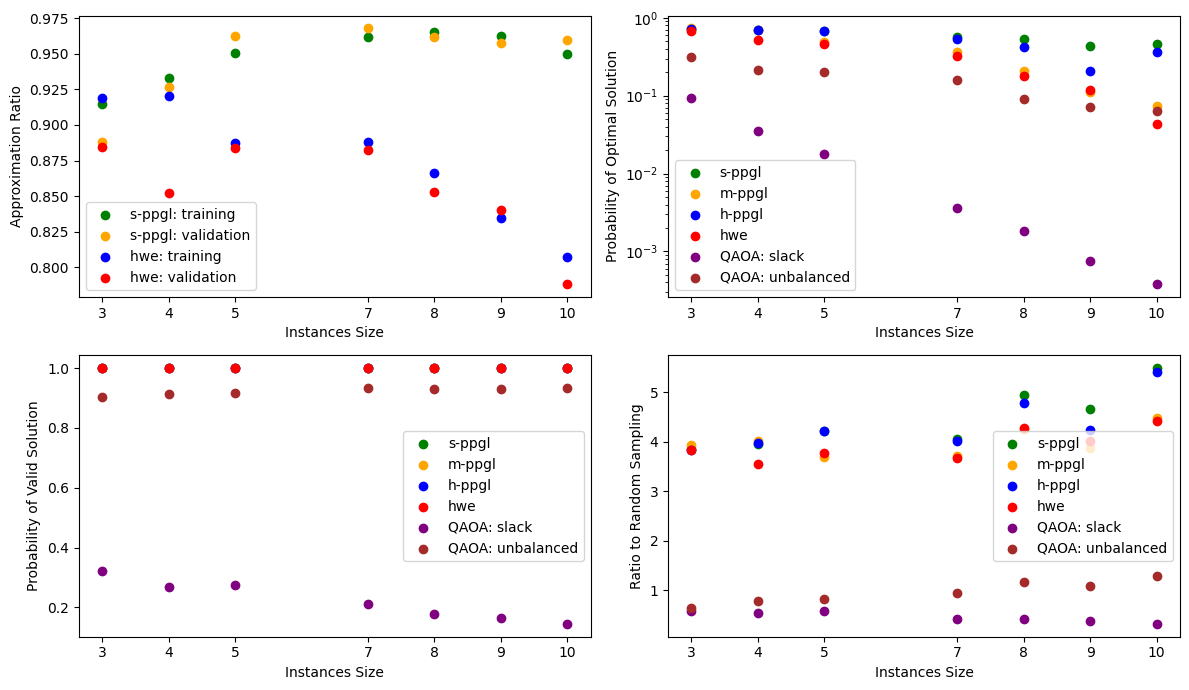

In [36]:
import matplotlib.pyplot as plt

# Assuming you have defined `problem_sizes` and `dataset_size` somewhere in your code

fig, ax = plt.subplots(2,2,tight_layout = True, figsize = (12,7))

# Plot the data as a vertical scatter plot
for i,size in enumerate(problem_sizes):
    ax[0,0].scatter(size , np.mean(qrl_results["approximation_ratios"][f"{size}"]["=s-ppgl"]["test"]),color='green', label="s-ppgl: training" if i == 0 else None)
    ax[0,0].scatter(size, np.mean(qrl_results["approximation_ratios"][f"{size}"]["=s-ppgl"]["validation"]),color='orange', label="s-ppgl: validation" if i == 0 else None)
    ax[0,0].scatter(size, np.mean(hwe_results["approximation_ratios"][f"{size}"]["PG"]["test"]),color='blue', label="hwe: training" if i == 0 else None)
    ax[0,0].scatter(size , np.mean(hwe_results["approximation_ratios"][f"{size}"]["PG"]["validation"]),color='red', label="hwe: validation" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[0,0].set_xticks(custom_ticks)

ax[0,0].set_xlabel("Instances Size")
ax[0,0].set_ylabel("Approximation Ratio")

# Manually create legend
ax[0,0].legend(["s-ppgl: training", "s-ppgl: validation","hwe: training","hwe: validation"])


for i,size in enumerate(problem_sizes):
    ax[0,1].scatter(size, np.mean(qrl_results["optimal_probability"][f"{size}"]["=s-ppgl"]["validation"]),color='green', label="s-ppgl" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(qrl_results["optimal_probability"][f"{size}"]["=m-ppgl"]["validation"]),color='orange', label="m-ppgl" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(qrl_results["optimal_probability"][f"{size}"]["=h-ppgl"]["validation"]),color='blue', label="h-ppgl" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(hwe_results["optimal_probability"][f"{size}"]["PG"]["validation"]),color='red', label="hwe" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(qaoa_results_final["slack"][size]["optimal_probability"]),color='purple', label="QAOA: slack" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(qaoa_results_final["unbalanced"][size]["optimal_probability"]),color='brown', label="QAOA: unbalanced" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[0,1].set_xticks(custom_ticks)

ax[0,1].set_xlabel("Instances Size")
ax[0,1].set_ylabel("Probability of Optimal Solution")
ax[0,1].set_yscale("log")

# Manually create legend
ax[0,1].legend(["s-ppgl", "m-ppgl","h-ppgl","hwe", "QAOA: slack", "QAOA: unbalanced"])

for i,size in enumerate(problem_sizes):
    ax[1,0].scatter(size, np.mean(qrl_results["valid_probability"][f"{size}"]["=s-ppgl"]["validation"]),color='green', label="s-ppgl" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(qrl_results["valid_probability"][f"{size}"]["=m-ppgl"]["validation"]),color='orange', label="m-ppgl" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(qrl_results["valid_probability"][f"{size}"]["=h-ppgl"]["validation"]),color='blue', label="h-ppgl" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(hwe_results["valid_probability"][f"{size}"]["PG"]["validation"]),color='red', label="hwe" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(qaoa_results_final["slack"][size]["valid_probability"]),color='purple', label="QAOA: slack" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(qaoa_results_final["unbalanced"][size]["valid_probability"]),color='brown', label="QAOA: unbalanced" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[1,0].set_xticks(custom_ticks)

ax[1,0].set_xlabel("Instances Size")
ax[1,0].set_ylabel("Probability of Valid Solution")

# Manually create legend
ax[1,0].legend(["s-ppgl", "m-ppgl","h-ppgl","hwe", "QAOA: slack", "QAOA: unbalanced"])


for i,size in enumerate(problem_sizes):
    ax[1,1].scatter(size, np.mean(qrl_results["better_than_random"][f"{size}"]["=s-ppgl"]["validation"]),color='green', label="s-ppgl" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(qrl_results["better_than_random"][f"{size}"]["=m-ppgl"]["validation"]),color='orange', label="m-ppgl" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(qrl_results["better_than_random"][f"{size}"]["=h-ppgl"]["validation"]),color='blue', label="h-ppgl" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(hwe_results["better_than_random"][f"{size}"]["PG"]["validation"]),color='red', label="hwe" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(qaoa_results_final["slack"][size]["better_than_random"]),color='purple', label="QAOA: slack" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(qaoa_results_final["unbalanced"][size]["better_than_random"]),color='brown', label="QAOA: unbalanced" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[1,1].set_xticks(custom_ticks)

ax[1,1].set_xlabel("Instances Size")
ax[1,1].set_ylabel("Ratio to Random Sampling")

# Manually create legend
ax[1,1].legend(["s-ppgl", "m-ppgl","h-ppgl","hwe", "QAOA: slack", "QAOA: unbalanced"])

#Display the plot
plt.savefig("final_qaoaqrl_comparison_mean.pdf")
plt.show()